In [1]:
%matplotlib inline
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import timeit
import matplotlib.pyplot as plt

In [2]:
def probX(X,Xi,sigma):
    n = X.shape
    p = 0.0
    pi = 3.1415926535
    for i in range(n[0]):
        p += 1/(2*pi*sigma)**(n[1]/2) * torch.exp(- torch.sum((X[i,:]-Xi)**2,1)/sigma)
        
    return p/n[0]

In [3]:
def generator(X,K,h):
    
    vsq = 0.0
    n = K.shape
    for i in range(n[2]):
        Ki = K[:,:,i]
        Z = torch.matmul(Ki-Ki.t(),X.t()).t()
        vi = torch.tanh(Z)
        X = X + h*vi
        vsq += torch.norm(vi)**2
    return X, vsq

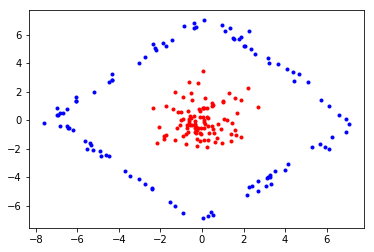

In [5]:
X = torch.randn(100,2)
Kt = torch.zeros(2,2,100)
Kt[0,1,:] = 2; Kt[1,0,:] = -2 
Y, vsq = generator(X,Kt,0.5)
plt.plot(X[:,0].numpy(),X[:,1].numpy(),'.r')
plt.plot(Y[:,0].numpy(),Y[:,1].numpy(),'.b')

tensor([[2.5999e-32, 9.6058e-32, 3.4621e-31,  ..., 7.6942e-33, 2.2343e-33,
         6.4055e-34],
        [8.7933e-32, 3.2488e-31, 1.1709e-30,  ..., 2.9612e-32, 8.6957e-33,
         2.5210e-33],
        [2.9012e-31, 1.0719e-30, 3.8635e-30,  ..., 1.1235e-31, 3.3363e-32,
         9.7812e-33],
        ...,
        [9.1669e-34, 3.6006e-33, 1.3799e-32,  ..., 7.1825e-28, 2.2109e-28,
         6.6389e-29],
        [2.6175e-34, 1.0285e-33, 3.9429e-33,  ..., 2.1847e-28, 6.7248e-29,
         2.0193e-29],
        [7.2969e-35, 2.8681e-34, 1.0999e-33,  ..., 6.4825e-29, 1.9953e-29,
         5.9916e-30]])

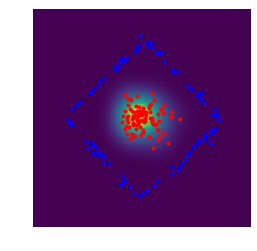

In [6]:
def plotProb(nn,a, sigma, X,Y=X):
    xx = torch.zeros(nn,nn); yy = torch.zeros(nn,nn)
    t = np.arange(0,nn); t = (2*a)* t/(np.float(nn)-1) - a


    for i in range(nn):
        for j in range(nn):
            xx[i,j] = np.float(t[i])
            yy[i,j] = np.float(t[j])

    Xi = torch.zeros(nn**2,2)
    Xi[:,0] = xx.view(-1); Xi[:,1] = yy.view(-1)

    P0 = probX(X,Xi,sigma)
    P0 = P0.view(nn,nn)

    plt.imshow(P0)
    plt.plot((a+X[:,1].numpy())/(2*a)*nn,(a+X[:,0].numpy())/(2*a)*nn,'.r')
    plt.plot((a+Y[:,1].numpy())/(2*a)*nn,(a+Y[:,0].numpy())/(2*a)*nn,'.b')
    
    plt.axis('off')
    return P0
    

plt.figure(2)    
plotProb(np.int64(128), 10.0, 2.0, X,Y)   

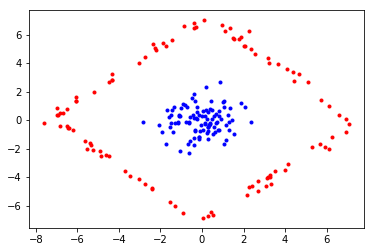

In [20]:
K        = torch.randn(2,2,Kt.shape[2])*0.001
#K[0,1,:] = 0.1;
#K[1,0,:] = -0.1;
K = nn.Parameter(K)

h  = 0.5
X  = torch.randn(100,2)
Yg, vsq = generator(X,K,h)
plt.plot(Y[:,0].numpy(),Y[:,1].numpy(),'.r')
plt.plot(Yg[:,0].detach().numpy(),Yg[:,1].detach().numpy(),'.b')

In [21]:
import torch.optim as optim
#optimizer    = optim.SGD([{'params':K}], lr=1.0, momentum=0)
optimizer    = optim.Adam([{'params':K}], lr=0.05)
sigma = 2.0

0 0.094655841588974 0.0946558341383934 3.823397308588028e-09 0.9998774528503418 0.9985634684562683
1 0.0710744559764862 0.07105480134487152 1.9651502990722656e-05 0.9997186660766602 0.9966738820075989
2 0.03837490826845169 0.03830104321241379 7.386608276367187e-05 0.9987421035766602 0.987426221370697
3 0.01380158681422472 0.013588052242994308 0.0002135347412109375 0.9893303513526917 0.9251114726066589
4 0.006017937790602446 0.0055789584293961525 0.00043897944335937497 0.9063396453857422 0.8193416595458984
5 0.00386308622546494 0.0031921679619699717 0.000670918310546875 0.7219510078430176 0.6790744662284851
6 0.002928141038864851 0.0020682611502707005 0.0008598797851562499 0.5649422407150269 0.5511851906776428
7 0.002426047809422016 0.0014256536960601807 0.0010003939453125 0.4572623670101166 0.4569685459136963
8 0.0021390796173363924 0.0010354359401389956 0.00110364365234375 0.37849366664886475 0.4003281891345978
9 0.002002070425078273 0.0008208707440644503 0.0011811996093749999 0.32486

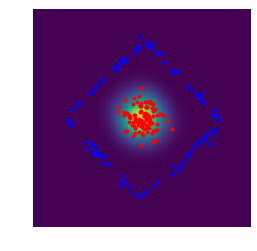

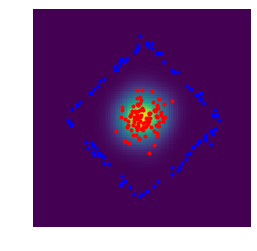

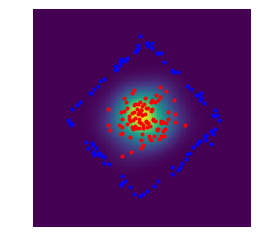

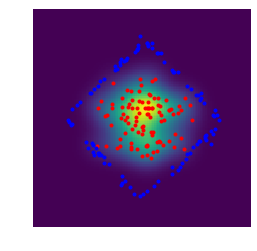

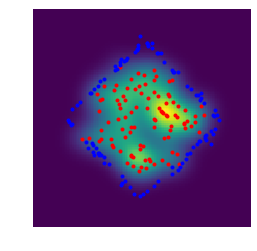

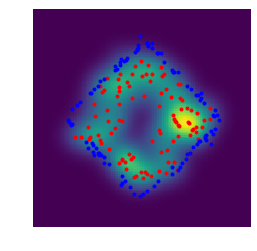

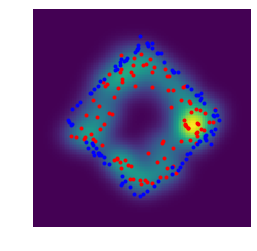

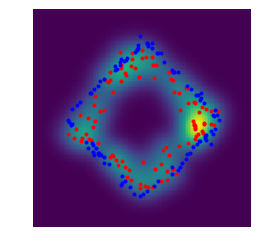

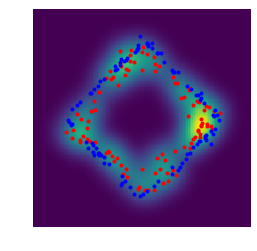

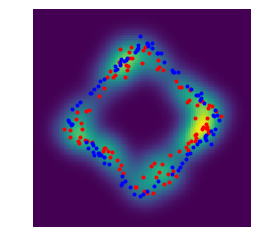

In [22]:
for epoch in range(10):  # loop over the dataset multiple times

        optimizer.zero_grad()
        # get the Y inputs
        Yg, vsq = generator(X,K,h)
        plt.figure(epoch)
        plotProb(np.int64(128), 10.0, 2.0, Yg.detach(),Y)
        
        #strg = 'epoch'+str(epoch)
        #plt.savefig(strg, dpi=100)


        p0 = probX(Y,Yg,sigma)
        p1 = probX(Yg,Yg,sigma)
        q0 = probX(Y,Y,sigma)
        q1 = probX(Yg,Y,sigma)
        
        mis1 = torch.norm(p0-p1)/torch.norm(p1)
        mis2 = torch.norm(q0-q1)/torch.norm(q0)

        misfit = torch.norm(p0-p1)**2 + torch.norm(q0-q1)**2
        regu   = vsq
        alpha = 1e-7
        loss = misfit + alpha*regu
        
        loss.backward()
        optimizer.step()
        if np.mod(epoch,1)==0:
            print(epoch, loss.item(), misfit.item(), alpha*regu.item(),mis1.item(),mis2.item()) 


print('Finished Training')